##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このノートブックでは、「[周期的構成の敵対的ネットワークを使った対となっていない画像から画像への変換](https://arxiv.org/abs/1703.10593)」で説明されているように、条件付き GAN を使用して対になっていない画像から画像への変換を実演します。周期的構成の敵対的ネットワークは、CycleGAN としても知られています。この論文では、対になっているトレーニングサンプルを使用せずに、1 つの画像領域の特性をキャプチャして、それらの特性を別の画像領域にどのように変換できるのかを見つけ出す方法が提案されています。

このノートブックは、Pix2Pix の知識があることを前提としています。Pix2Pix については、[Pix2Pix チュートリアル](https://www.tensorflow.org/tutorials/generative/pix2pix)をご覧ください。CycleGAN のコードは類似していますが、主な違いは、追加の損失関数があり、対になっていないトレーニングデータを使用する点にあります。

CycleGAN では、周期的に一貫した損失を使用して、対になっているデータを必要とせずにトレーニングすることができます。言い換えると、ソースとターゲット領域で 1 対 1 のマッピングを行わずに、1 つの領域から別の領域に変換することができます。

この方法により、写真補正、カラー画像化、画風変換といった興味深い多様なタスクが可能となります。これらのタスクに必要となるのは、ソースとターゲットデータセット（単純な画像ディレクトリ）のみです。

![出力画像 1](https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/images/horse2zebra_1.png?raw=1) ![出力画像 2](https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/images/horse2zebra_2.png?raw=1)

## 入力パイプラインをセットアップする

ジェネレータとディスクリミネータのインポートを実行する [tensorflow_examples](https://github.com/tensorflow/examples) パッケージをインストールします。

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-wvq1iv_7
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-wvq1iv_7
  Resolved https://github.com/tensorflow/examples.git to commit 652ee34ff046946c36b8aed5d97ecebab0699f7e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1734446297.577653703822934887080861169866359378810363289470-py3-none-any.whl size=301604 sha256=eb50ce9b497a58694cc82c0645182229e26f22f4d248a607f8517c9fe3585a22
  Stored in directory: /tmp/pip-ephem-wheel-cache-mm0v10o9/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## 入力パイプライン

このチュートリアルでは、馬の画像からシマウマの画像に変換できるようにモデルをトレーニングします。このデータセットとこれに類似したほかのデータセットは、[こちら](https://www.tensorflow.org/datasets/datasets#cycle_gan)にあります。

[論文](https://arxiv.org/abs/1703.10593)に記載されているように、トレーニングデータセットに、ランダムジッタリングとミラーリングを適用します。これらは、過学習を避ける画像認識精度向上テクニックです。

これは、[pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset) で行われていたものに似ています。

- ランダムジッタリングでは、画像サイズは `286 x 286` に変換されてから、`256 x 256` にランダムにクロップされます。
- ランダムミラーリングでは、画像はランダムに水平方向（左から右）に反転されます。

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from google.colab import drive
import os

# Google Driveをマウント（永続的に保存したい場合）
drive.mount('/content/drive')

# 保存先ディレクトリを指定（Google Drive内）
save_dir = '/content/drive/My Drive/cycle_gan_dataset'
os.makedirs(save_dir, exist_ok=True)

# データセットをダウンロード
dataset, metadata = tfds.load('cycle_gan/monet2photo',
                              with_info=True, as_supervised=True,
                              data_dir=save_dir)  # 保存先を指定

# データを分割
train_monet, train_photo = dataset['trainA'], dataset['trainB']
test_monet, test_photo = dataset['testA'], dataset['testB']

# 確認
print(f"データセットが保存されたディレクトリ: {save_dir}")
print(f"Train Monet samples: {len(list(train_monet))}")
print(f"Train Photo samples: {len(list(train_photo))}")


Mounted at /content/drive
データセットが保存されたディレクトリ: /content/drive/My Drive/cycle_gan_dataset
Train Monet samples: 1072
Train Photo samples: 6287


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_monets = train_monet.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_photos = train_photo.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_monets = test_monet.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_photos = test_photo.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_monet = next(iter(train_monets))
sample_photo = next(iter(train_photos))

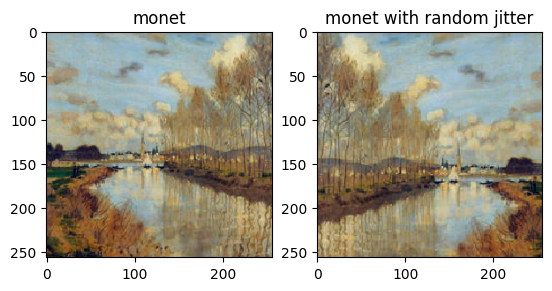

In [ ]:
plt.subplot(121)
plt.title('monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('monet with random jitter')
plt.imshow(random_jitter(sample_monet[0]) * 0.5 + 0.5)

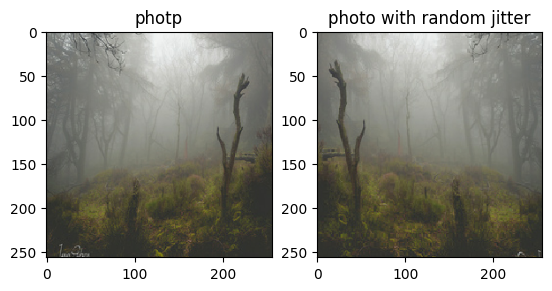

In [ ]:
plt.subplot(121)
plt.title('photp')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

## Pix2Pix モデルをインポートしてサイズ変更する

インストールした [tensorflow_examples](https://github.com/tensorflow/examples) を介して [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) で使用したジェネレータとディスクリミネータをインポートします。

このチュートリアルで使用されるモデルアーキテクチャは、[pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) で使用されたものに非常によく似ていますが、以下のような違いがあります。

- Cyclegan は、[バッチ正規化](https://arxiv.org/abs/1502.03167)ではなく[インスタンス正規化](https://arxiv.org/abs/1607.08022)を使用します。
- [CycleGAN の論文](https://arxiv.org/abs/1703.10593)では、変更が適用された `resnet` ベースのジェネレータが使用されています。このチュートリアルでは、単純化するために、変更を適用した `unet` ジェネレータを使用しています。

ここでトレーニングされるのは、以下のような 2 つのジェネレータ（G と F）と 2 つのディスクリミネータ（X と Y）です。

- ジェネレータ `G` は、画像 `X` を画像 `Y` に変換する方法を学習します。$(G: X -&gt; Y)$
- ジェネレータ `F` は、画像 `Y` を画像 `X` に変換する方法を学習します。$(F: Y -&gt; X)$
- ディスクリミネータ `D_X` は、画像 `X` と生成された画像 `X`（`F(Y)`）を区別する方法を学習します。
- ディスクリミネータ `D_Y` は、画像 `Y` と生成された画像 `Y`（`G(X)`）を区別する方法を学習します。

![Cyclegan モデル](https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/images/cyclegan_model.png?raw=1)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

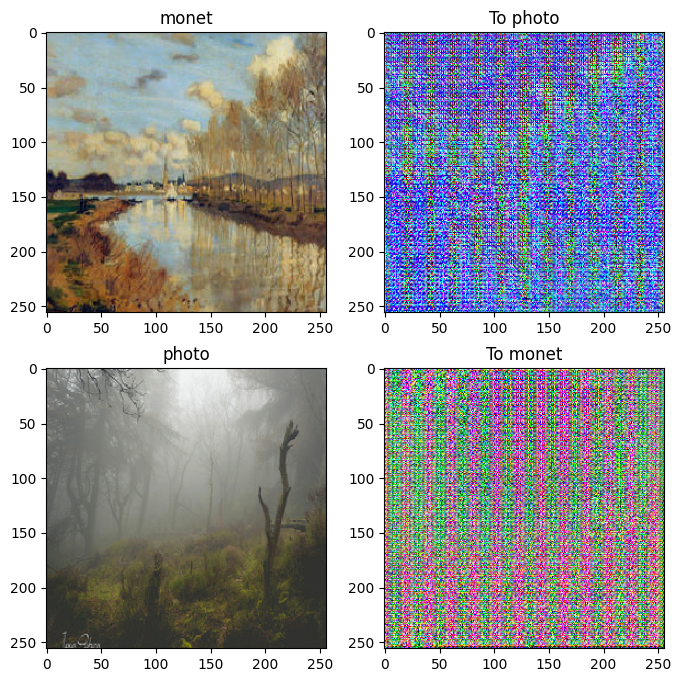

In [ ]:
to_photo = generator_g(sample_monet)
to_monet = generator_f(sample_photo)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_monet, to_photo, sample_photo, to_monet]
title = ['monet', 'To photo', 'photo', 'To monet']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

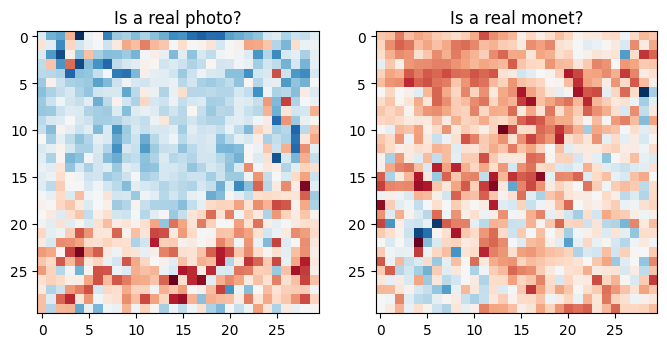

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real photo?')
plt.imshow(discriminator_y(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real monet?')
plt.imshow(discriminator_x(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 損失関数

CycleGAN では、トレーニングできる、対になったデータが存在しないため、トレーニング中の入力 `x` とターゲット `y` のペアに意味がある保証はありません。したがって、ネットワークによる的確なマッピングを強化するために、論文の執筆者は 周期的に一貫性のある損失を提案しています。

ディスクリミネータ損失とジェネレータ損失は [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer) で使用されているものに似ています。

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

周期的一貫性とは、結果が元の入力に近いことを指します。たとえば、ある文を英語からフランス語に翻訳してから、フランス語から英語に戻す場合、結果として得られる文は元の文と同じになるということです。

周期的一貫性損失は、以下のように行われます。

- 画像 $X$ はジェネレータ $G$ を介して渡され、画像 $\hat{Y}$ を生成します。
- 生成された画像 $\hat{Y}$ はジェネレータ $F$ を介して渡され、周期後の画像 $\hat{X}$ を生成します。
- $X$ と $\hat{X}$ 間の平均絶対誤差が計算されます。

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$

![Cycle loss](https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/images/cycle_loss.png?raw=1)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

上記に示す通り、画像 $X$ から画像 $Y$ への変換は、ジェネレータ $G$ が行います。 アイデンティティ損失は、画像 $Y$ をジェネレータ $G$ にフィードした場合、実際の $Y$ または画像 $Y$ に近い画像を生成すると記述できます。

馬に対してシマウマから馬モデルを実行するか、シマウマに対して馬からシマウマモデルを実行する場合、画像にはすでにターゲットクラスが含まれるため、画像はそれほど変更されません。

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

すべてのジェネレータとディスクリミネータのオプティマイザを初期化します。

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## チェックポイント

## トレーニング

注意: このサンプルモデルは、このチュートリアルのトレーニング時間を合理的にするために、論文（200 回）よりも少ないエポック数（10）でトレーニングされています。生成された画像の品質は大幅に低下します。

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

トレーニングループは複雑に見えるかもしれませんが、以下の 4 つの基本ループで構成されています。

- 予測を取得する。
- 損失を計算する。
- バックプロパゲーションを使用して勾配を計算する。
- 勾配をオプティマイザに適用する。

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

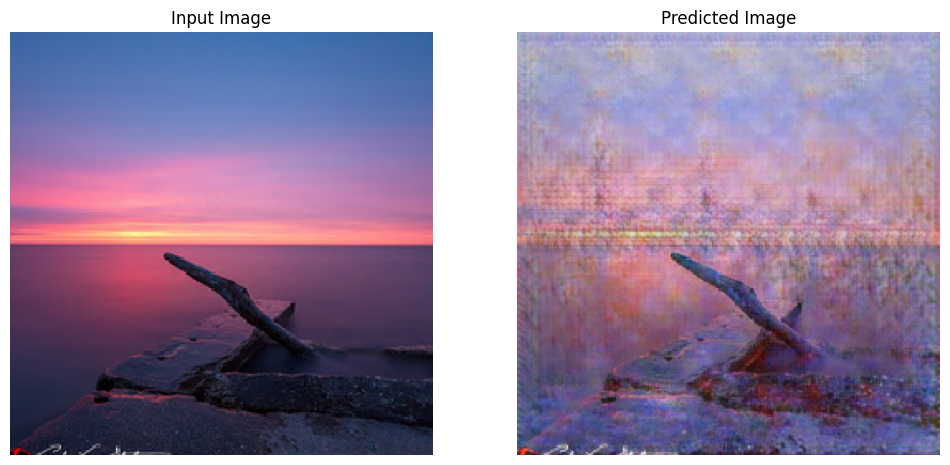

Time taken for epoch 11 is 504.0042908191681 sec

........................................................................................................

In [ ]:
# Google Driveをマウント
drive.mount('/content/drive')

# Google Drive内の保存先ディレクトリ
checkpoint_dir = '/content/drive/My Drive/cycle_gan_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# TensorFlowのチェックポイントマネージャをセットアップ
ckpt = tf.train.Checkpoint(generator_f=generator_f, generator_g=generator_g,
                           discriminator_x=discriminator_x, discriminator_y=discriminator_y,
                           generator_f_optimizer=generator_f_optimizer,
                           generator_g_optimizer=generator_g_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

# 最新のチェックポイントを復元
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored from:', ckpt_manager.latest_checkpoint)

# 学習ループ
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_monets, train_photos)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    clear_output(wait=True)
    # 学習の進捗確認のために画像を生成
    generate_images(generator_f, sample_photo)

    # 5エポックごとにチェックポイントを保存
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))


## テストデータセットを使用して生成する

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Latest checkpoint restored from: /content/drive/My Drive/cycle_gan_checkpoints/ckpt-6


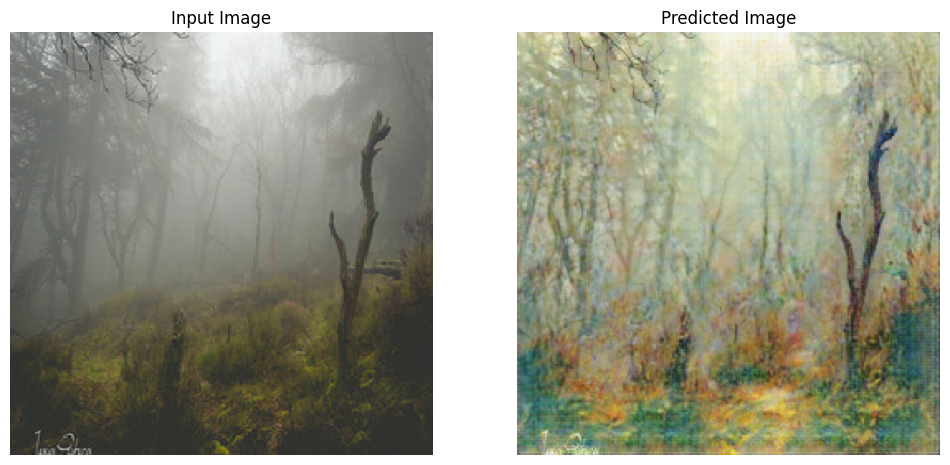

In [ ]:
# Google Driveをマウント
drive.mount('/content/drive')

# Google Drive内の保存先ディレクトリ
checkpoint_dir = '/content/drive/My Drive/cycle_gan_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# TensorFlowのチェックポイントマネージャをセットアップ
ckpt = tf.train.Checkpoint(generator_f=generator_f, generator_g=generator_g,
                           discriminator_x=discriminator_x, discriminator_y=discriminator_y,
                           generator_f_optimizer=generator_f_optimizer,
                           generator_g_optimizer=generator_g_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

# チェックポイントを復元
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored from:', ckpt_manager.latest_checkpoint)
    generate_images(generator_f, sample_photo)

In [ ]:
import os
import matplotlib.pyplot as plt

# Google Drive内に結果保存用のディレクトリを作成
result_dir = '/content/drive/My Drive/cycle_gan_result'
os.makedirs(result_dir, exist_ok=True)

# Run the trained model on the test dataset and save results
for idx, inp in enumerate(test_photo):
    image, label = inp  # ラベルを無視して画像データのみ取得
    image = tf.expand_dims(image, axis=0)  # バッチ次元を追加
    image = tf.cast(image, tf.float32)  # 型を float32 に変換
    image = (image / 127.5) - 1  # 値を [-1, 1] に正規化

    # 画像を生成
    prediction = generator_f(image)

    # 結果を [0, 255] の範囲に戻す
    result_image = (prediction[0] + 1) * 127.5  # [-1, 1] -> [0, 255]
    result_image = tf.cast(result_image, tf.uint8)  # uint8に変換

    # 元の画像のファイル名を取得（例: "image1.jpg"）
    original_filename = f"image_{idx + 1}.jpg"  # 必要に応じて調整
    new_filename = os.path.splitext(original_filename)[0] + "_1.jpg"  # "_1"を追加

    # 保存するファイルのパスを決定
    result_file = os.path.join(result_dir, new_filename)

    # 画像を保存
    plt.imshow(result_image)
    plt.axis('off')
    plt.savefig(result_file, bbox_inches='tight', pad_inches=0)
    plt.close()

    print(f"Saved generated image {idx + 1} to {result_file}")

print("All images have been generated and saved.")


Saved generated image 1 to /content/drive/My Drive/cycle_gan_result/image_1_1.jpg
Saved generated image 2 to /content/drive/My Drive/cycle_gan_result/image_2_1.jpg
Saved generated image 3 to /content/drive/My Drive/cycle_gan_result/image_3_1.jpg
Saved generated image 4 to /content/drive/My Drive/cycle_gan_result/image_4_1.jpg
Saved generated image 5 to /content/drive/My Drive/cycle_gan_result/image_5_1.jpg
Saved generated image 6 to /content/drive/My Drive/cycle_gan_result/image_6_1.jpg
Saved generated image 7 to /content/drive/My Drive/cycle_gan_result/image_7_1.jpg
Saved generated image 8 to /content/drive/My Drive/cycle_gan_result/image_8_1.jpg
Saved generated image 9 to /content/drive/My Drive/cycle_gan_result/image_9_1.jpg
Saved generated image 10 to /content/drive/My Drive/cycle_gan_result/image_10_1.jpg
Saved generated image 11 to /content/drive/My Drive/cycle_gan_result/image_11_1.jpg
Saved generated image 12 to /content/drive/My Drive/cycle_gan_result/image_12_1.jpg
Saved gene

KeyboardInterrupt: 

## 次のステップ

このチュートリアルでは、[Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) チュートリアルで実装されたジェネレータとディスクリミネータを使って CycleGAN を実装する方法を紹介しました。次のステップとして、[TensorFlow データセット](https://www.tensorflow.org/datasets/datasets#cycle_gan)の別のデータセットを使用して試してみてください。

また、エポック数を増加してトレーニングし、結果がどのように改善されるか確認することもできます。さらに、ここで使用した U-Net ジェネレータの代わりに[論文](https://arxiv.org/abs/1703.10593)で使用されている変更された ResNet ジェネレータを実装してみるのもよいでしょう。